<a href="https://colab.research.google.com/github/khanel/ImageSegmentation/blob/main/InstanceSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I was think about an algorithm that uses a detection model first to find objects in the image and then another model to track these objects, and it would use lesser resources and also be very fast in theory. but my current knowledge doesn't let me to put this idea into action.
instead I searched about effective object detection methods and decided to use mask r-cnn.

this notebook has no limiting dependency on anything and can be run without any kind of error.
the files are online and will be downloaded at runtime.
all frameworks and packages are already installed on colab.

###Set up

In [ ]:
import torch
import torchvision

In [ ]:
# official mask rcnn by pytorch, note: its on beta version and no backward compatibility is guarantreed
# it is using resnet 50 as the detection backbone
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# I just want to use it as it is trained and not tune it anymore
model.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
model = model.cuda() #using GPU

In [ ]:
# its for labeling the detected classes
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

len(COCO_INSTANCE_CATEGORY_NAMES) # 91 classes including background

91

In [ ]:
from PIL import Image
from torchvision import transforms as T
import numpy as np
import cv2

mask r-cnn produce three output: one for classes(detection part), one for boxes surronding objects, and one for masks covering each object
depending on the objects we are dealing with, we can choose different beckbone for detection part.

more information on [Mask R-CNN](https://arxiv.org/pdf/1703.06870.pdf)
architecture of this model is as follows:
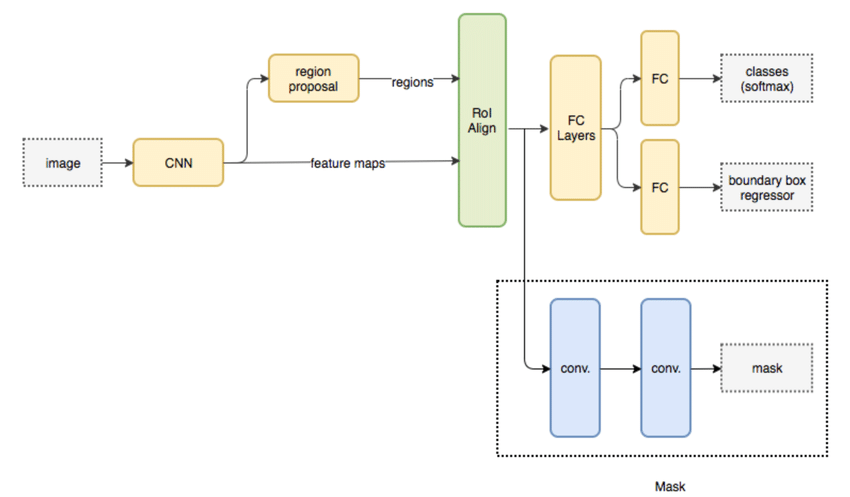

In [ ]:
# a function to get model prediction and extract masks, labels and boxes
def get_prediction(img, threshold=0.5):
  transform = T.Compose([T.ToTensor()]) # Turn the image into a torch.tensor
  img = transform(img)
  img = img.cuda() 
  pred = model([img]) # Send the image to the model. This runs on CPU, so its going to take time
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [ ]:
#cv2.imshow() is not supported in colab notebook, i will use plt.imshow() instead
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [ ]:
import random

In [ ]:
# put mask on detected areas in images
def random_color_masks(image):
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask

In [ ]:
#this function will get the detected masks and labels and put them into the image
def instance_segmentation(img,
                          threshold=0.5,
                          rect_th=3,
                          text_size=3,
                          text_th=3,
                          ):
  
  masks, boxes, pred_cls = get_prediction(img, threshold=threshold)
  
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR
  
  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img, boxes[i][0], boxes[i][1], color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img, pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
  # masks and labels are puted in the image but for probable future usages labels and masks will also retured, we can use get pridiction instead and remove label and mask here
  return img, pred_cls, masks[i]

###Evaluation


##Image
let's first try it on a single image and see its accuracy in a static situation that performance and time are not much important.

In [ ]:

!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg -O car.jpg

--2022-07-13 18:17:48--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2178423 (2.1M) [image/jpeg]
Saving to: ‘car.jpg’

car.jpg             100%[===================>]   2.08M  --.-KB/s    in 0.007s  

2022-07-13 18:17:48 (278 MB/s) - ‘car.jpg’ saved [2178423/2178423]



In [ ]:
img = cv2.imread('./car.jpg')
img, pred_classes, masks = instance_segmentation(img, rect_th=5, text_th=4)

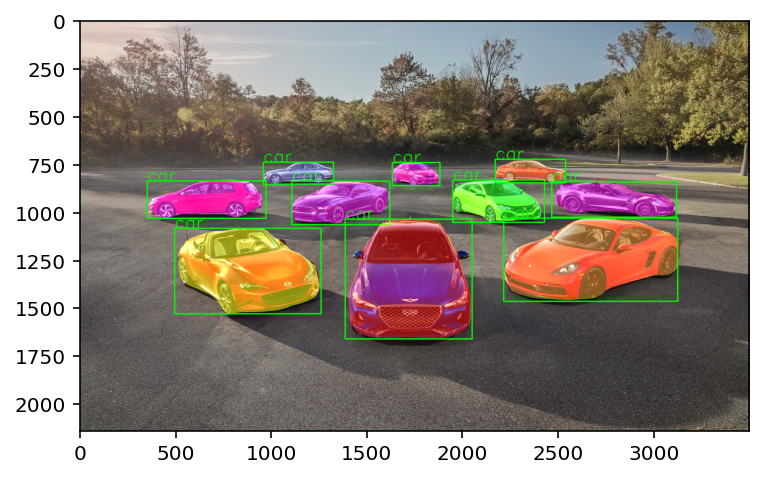

In [ ]:
plt.imshow(img)

##Video
to try its performance on processing video frames.
note that we dont need a large scale full of detail frame for detecting objects and masking them in videos, I preprocessed video to have smaller scale and also reduced FPS to 15.
we can do it ongoing and for streaming videos its necessary.
the output would write into a file named "output.mp4".

In [ ]:
!wget -O cars.mp4 https://files.catbox.moe/15yakl.mp4

In [ ]:
cap = cv2.VideoCapture("cars.mp4")

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 15, (1080,606))

fps = 15
c = 0
while(cap.isOpened()):
    ret, frame = cap.read()

    if not ret:
        break
        
    frame, pred_classes, masks = instance_segmentation(frame, rect_th=5, text_th=4)
    out.write(frame)
    
    
     
cap.release()
out.release()